In [1]:
import xarray as xr
import cartopy.crs as ccrs
import numpy as np


ds_GFD_info = xr.open_dataset("/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/outputs/GreenSurge_Tonga_info_updated.nc")
ds_GFD_info

/tmp/ipykernel_2208321/2131668362.py:6: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_GFD_info = xr.open_dataset("/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/outputs/GreenSurge_Tonga_info_updated.nc")


<xarray.Dataset> Size: 4MB
Dimensions:                            (element_computation_index: 151076,
                                        triangle_forcing_nodes: 3,
                                        node_forcing_index: 20,
                                        element_forcing_index: 25,
                                        wind_direction_index: 24,
                                        time_forcing_index: 4,
                                        node_cumputation_index: 76754)
Coordinates:
  * wind_direction_index               (wind_direction_index) int32 96B 0 ... 23
  * time_forcing_index                 (time_forcing_index) datetime64[ns] 32B ...
    node_computation_longitude         (node_cumputation_index) float64 614kB ...
    node_computation_latitude          (node_cumputation_index) float64 614kB ...
    triangle_nodes                     (triangle_forcing_nodes) int32 12B ...
  * node_forcing_index                 (node_forcing_index) int32 80B 0 1 ... 19
  * element_forcing_index              (element_forcing_index) int32 100B 0 ....
  * node_cumputation_index             (node_cumputation_index) int32 307kB 0...
  * element_computation_index          (element_computation_index) int32 604kB ...
Dimensions without coordinates: triangle_forcing_nodes
Data variables: (12/14)
    triangle_computation_connectivity  (element_computation_index, triangle_forcing_nodes) int32 2MB ...
    node_forcing_longitude             (node_forcing_index) float64 160B ...
    node_forcing_latitude              (node_forcing_index) float64 160B ...
    triangle_forcing_connectivity      (element_forcing_index, triangle_forcing_nodes) int32 300B ...
    wind_directions                    (wind_direction_index) int32 96B ...
    total_elements                     int32 4B ...
    ...                                 ...
    wind_speed                         int32 4B ...
    location_name                      object 8B ...
    eddy_viscosity                     int32 4B ...
    chezy_coefficient                  int32 4B ...
    reference_date                     object 8B ...
    forcing_time_step                  float64 8B ...
Attributes:
    title:        Hybrid Simulation Input Dataset
    description:  Structured dataset containing simulation parameters for hyb...
    created:      2025-05-31 15:29:42
    institution:  GeoOcean
    model:        GreenSurge

In [2]:
from bluemath_tk.tcs.tracks import historic_track_preprocessing, historic_track_interpolation

p_ibtracs = "/lustre/geocean/DATA/GEOOCEAN/IBTrACS.ALL.v04r00.nc"

ibtracs = xr.open_dataset(p_ibtracs)

name = b'HAROLD'
TCname = 'HAROLD2020'
year = 2020
centerID = 'WMO'

storm = ibtracs.isel(
   storm = np.where(
       (ibtracs.name == name) &  # TODO: necesita \ ?
       (ibtracs.time[:,0].dt.year.values == year)
   )[0]
).isel(storm=0)

df_TC_hist = historic_track_preprocessing(storm, center = centerID)

# computational time step mandatory [60 min] for GS methodology: 
dt_comp = (ds_GFD_info.time_step_hours.values/ np.timedelta64(1, 'm')).astype(int)

# generate interpolated storm track and mandatory data to apply vortex model 
storm_track, time_input = historic_track_interpolation(df_TC_hist, dt_comp)

864


/vols/abedul/home/grupos/geocean/faugeree/BlueMath_tk/bluemath_tk/tcs/tracks.py:1065: FutureWarning: 'MIN' is deprecated and will be removed in a future version, please use 'min' instead.
  time_input0 = pd.date_range(


In [3]:
tini = np.datetime64('2020-04-07T00:00')
tend = np.datetime64('2020-04-09T17:00')

storm_track_sel = storm_track[(storm_track.index >= tini) & (storm_track.index <= tend)]

In [4]:
from bluemath_tk.additive.greensurge import get_regular_grid

lon_grid, lat_grid = get_regular_grid(
    ds_GFD_info.node_computation_longitude.values,
    ds_GFD_info.node_computation_latitude.values,
    ds_GFD_info.triangle_computation_connectivity.values,
    factor=10
)

In [5]:
from bluemath_tk.tcs.vortex import vortex_model_grid

xds_vortex_GS = vortex_model_grid(storm_track_sel, lon_grid, lat_grid)

In [6]:
from bluemath_tk.additive.greensurge import generate_structured_points

lon_all, lat_all = generate_structured_points(
    ds_GFD_info.triangle_forcing_connectivity.values,
    ds_GFD_info.node_forcing_longitude.values,
    ds_GFD_info.node_forcing_latitude.values
)

<Figure size 600x600 with 0 Axes>

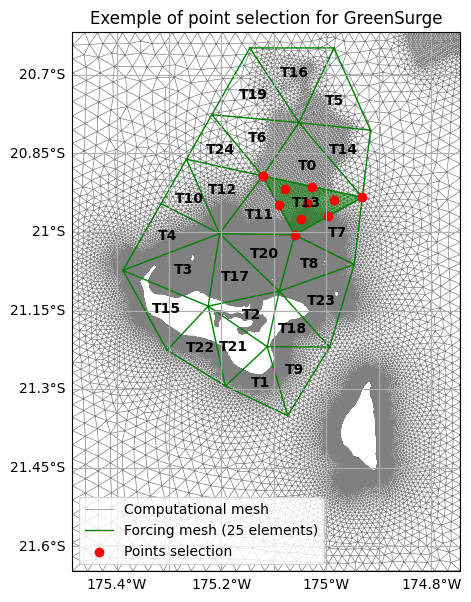

In [7]:
from bluemath_tk.additive.greensurge import plot_greensurge_setup
import matplotlib.pyplot as plt

i = 13

lon_points = lon_all[i]
lat_points = lat_all[i]
triangle = np.array([
    [lon_points[0], lat_points[0]],
    [lon_points[1], lat_points[1]],
    [lon_points[2], lat_points[2]],
    [lon_points[0], lat_points[0]] ])

plt.figure(figsize=(6, 6))
fig, ax = plot_greensurge_setup(ds_GFD_info, figsize=(7, 7))
ax.fill(triangle[:, 0], triangle[:, 1], color='green', alpha=0.5, transform=ccrs.PlateCarree())
ax.scatter(lon_points, lat_points, color='red', marker='o', transform=ccrs.PlateCarree(), 
           label='Points selection')
ax.set_title("Exemple of point selection for GreenSurge")
ax.legend()


In [8]:
n_tri, n_pts = lat_all.shape
n_time = xds_vortex_GS.dims['time']

lat_interp = xr.DataArray(
    lat_all.reshape(-1),
    dims="point"
)
lon_interp = xr.DataArray(
    lon_all.reshape(-1),
    dims="point"
)

W_interp = xds_vortex_GS.W.interp(lat=lat_interp, lon=lon_interp)
Dir_interp = xds_vortex_GS.Dir.interp(lat=lat_interp, lon=lon_interp)
p_interp = xds_vortex_GS.p.interp(lat=lat_interp, lon=lon_interp)

W_interp = W_interp.values.reshape(n_tri, n_pts,-1)
Dir_interp = Dir_interp.values.reshape(n_tri, n_pts,-1)
p_interp = p_interp.values.reshape(n_tri, n_pts,-1)

theta_rad = np.deg2rad(Dir_interp)
u = np.cos(theta_rad)
v = np.sin(theta_rad)
u_mean = u.mean(axis=1)
v_mean = v.mean(axis=1)
Dir_mean = (np.rad2deg(np.arctan2(v_mean, u_mean))) % 360

xds_vortex_interp = xr.Dataset(
    data_vars={
        "W": (("element", "time"), W_interp.mean(axis=1)),
        "Dir": (("element", "time"), Dir_mean),
        "p": (("element", "time"), p_interp.mean(axis=1)),
    },
    coords={
        "time": xds_vortex_GS.time.values,
        "element": np.arange(n_tri)
    }
)

/tmp/ipykernel_2208321/2049842878.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_time = xds_vortex_GS.dims['time']


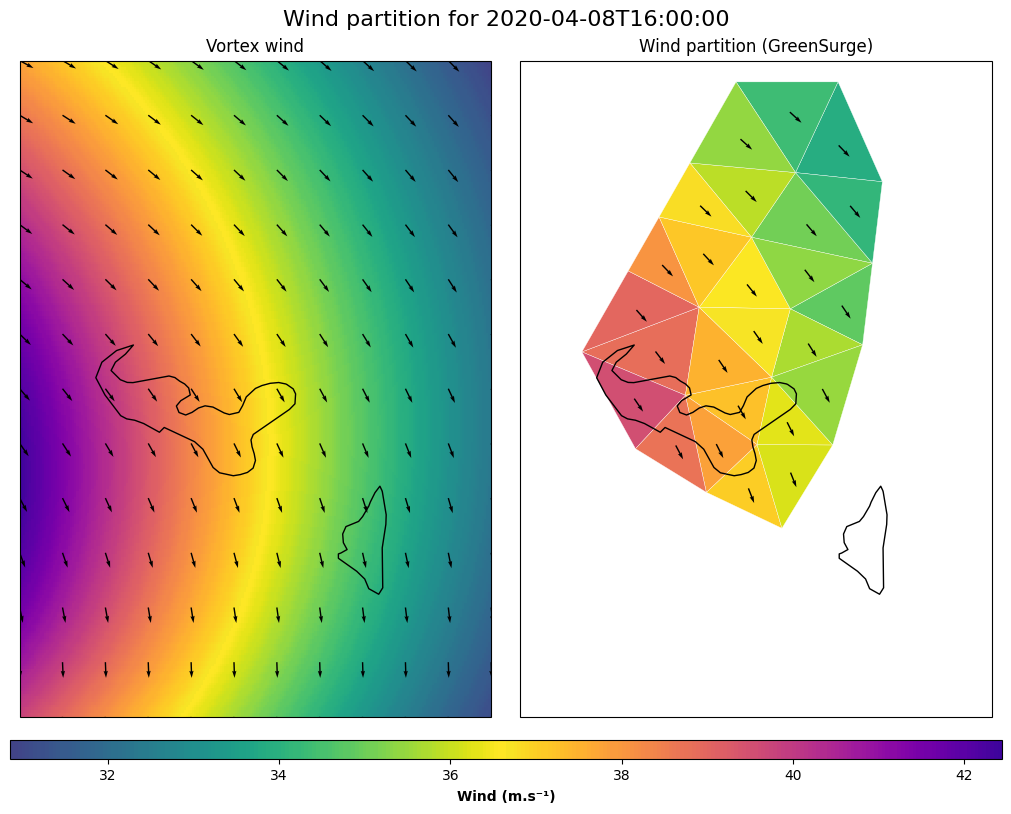

In [9]:
from bluemath_tk.additive.greensurge import plot_GS_input_wind_partition

plot_GS_input_wind_partition(xds_vortex_GS, xds_vortex_interp, ds_GFD_info, i_time=160)

In [10]:
p_GFD_libdir = "/lustre/geocean/DATA/extra_work/faugeree/Tonga_GreenSurge/GreenSurge_Postprocess"

In [11]:
import numpy as np

tini = np.datetime64("2020-04-08T00:00")
tend = np.datetime64("2020-04-08T12:00")

In [12]:
wind_direction_interp = xds_vortex_interp.Dir

wind_direction_database = ds_GFD_info.wind_directions.values
wind_direction_step = np.mean(np.diff(wind_direction_database)) 
wind_direction_indices = ((np.round((wind_direction_interp.values % 360) / wind_direction_step)) % len(wind_direction_database)).astype(int)
unique_direction_indices = np.unique(wind_direction_indices).astype(str)

green_surge_file_paths = np.char.add(
    np.char.add(p_GFD_libdir + "/GreenSurge_DB_", unique_direction_indices),
    ".nc"
)

def preprocess(dataset):
    file_name = dataset.encoding.get('source', 'Unknown')
    direction_string = file_name.split('_DB_')[-1].split('.')[0]
    direction_index = int(direction_string)
    return dataset[["mesh2d_s1"]].expand_dims("direction").assign_coords(direction=[direction_index])

greensurge_dataset = xr.open_mfdataset(
    green_surge_file_paths,
    parallel=False,
    combine="by_coords",
    preprocess=preprocess,
    engine="netcdf4"
)

In [ ]:
from bluemath_tk.additive.greensurge import GS_windsetup_reconstruction_with_postprocess

xds_GS_wind = GS_windsetup_reconstruction_with_postprocess(
    greensurge_dataset,
    ds_GFD_info,
    xds_vortex_interp,
)

In [14]:
ds_WL_dynamic_WindSetUp = xr.open_dataset("/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/inputs/GreenSurge_GFDcase_map.nc")

/vols/abedul/home/grupos/geocean/faugeree/BlueMath_tk/bluemath_tk/additive/greensurge.py:404: RuntimeWarning: All-NaN slice encountered
  xds_DY = np.nanmax(ds_WL_dynamic_WindSetUp["mesh2d_s1"].values, axis=0)


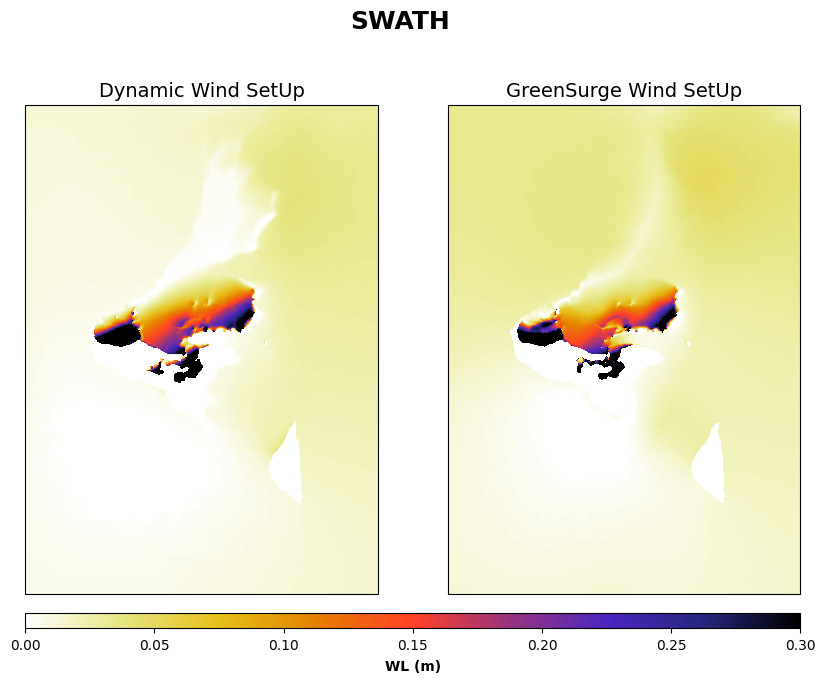

In [15]:
from bluemath_tk.additive.greensurge import plot_GS_vs_dynamic_windsetup_swath

plot_GS_vs_dynamic_windsetup_swath(xds_GS_wind, ds_WL_dynamic_WindSetUp, ds_GFD_info, vmin=0, vmax=0.3)

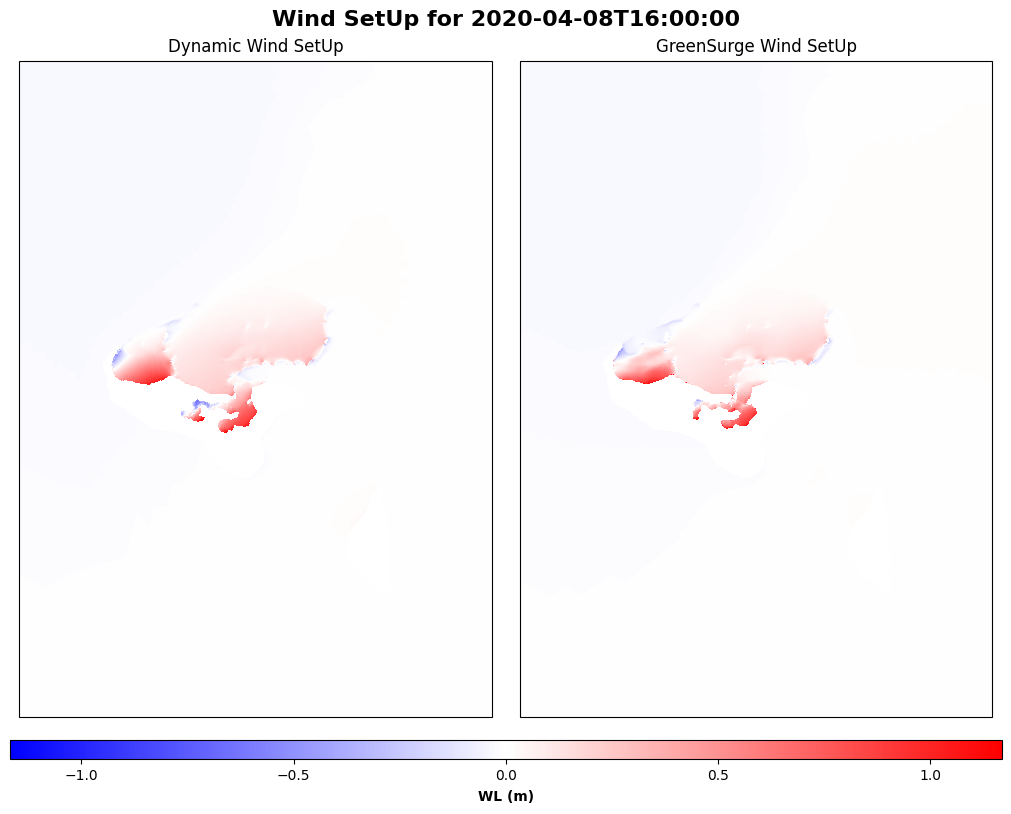

In [16]:
from bluemath_tk.additive.greensurge import plot_GS_vs_dynamic_windsetup

plot_GS_vs_dynamic_windsetup(xds_GS_wind, ds_WL_dynamic_WindSetUp, ds_GFD_info, xds_vortex_interp.time[160].values)

In [17]:
tide_gauge = xr.open_dataset("/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/inputs/TG_HAROLD2020_Tongatapu.nc")

In [18]:
from bluemath_tk.additive.greensurge import pressure_to_IB

ds_WL_GS_IB = pressure_to_IB(xds_vortex_GS)

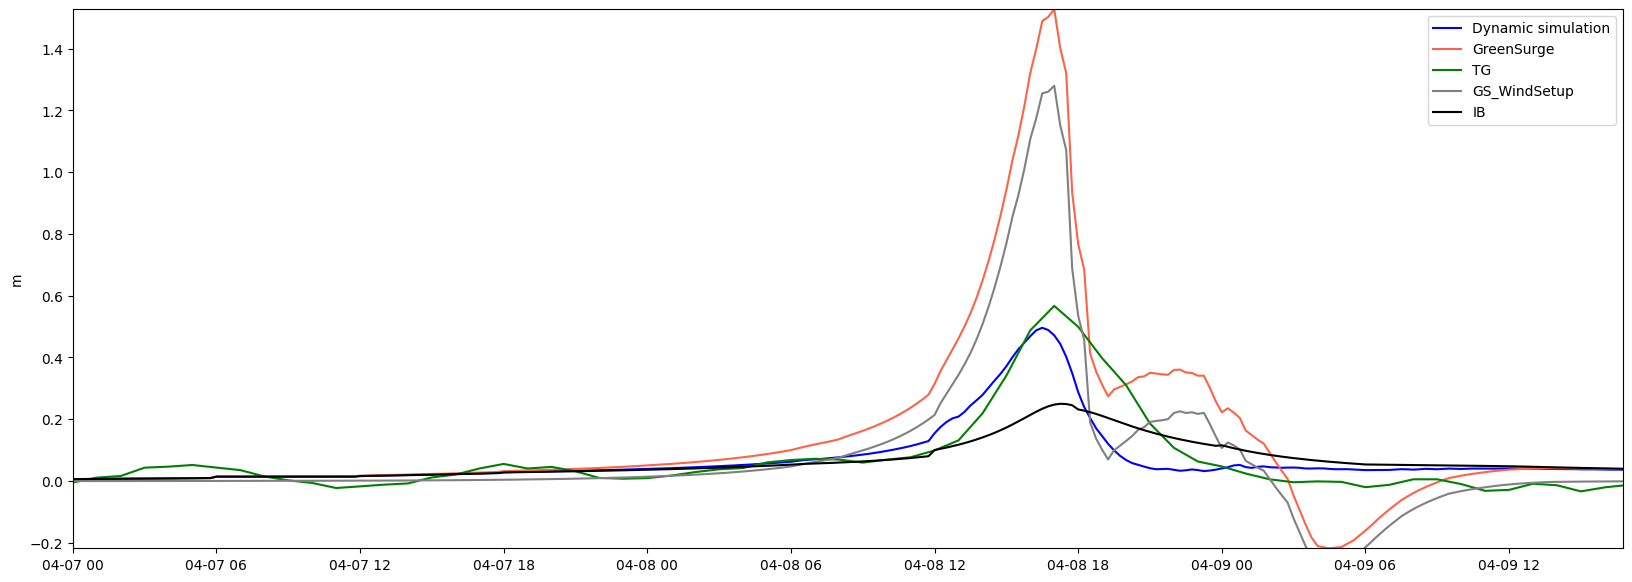

In [19]:
from bluemath_tk.additive.greensurge import plot_GS_TG_validation_timeseries_tri

plot_GS_TG_validation_timeseries_tri(
    xds_GS_wind, ds_WL_GS_IB, 
    ds_WL_dynamic_WindSetUp,
    tide_gauge,
    ds_GFD_info,
    figsize = [20,7],
)